<a href="https://colab.research.google.com/github/ChrisKantor/Deep-Learning/blob/main/Project%201/Deep_Learning_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Deep Learning model that can identify the state of different cooking ingredients

#submit accuracy/loss figures for each epoch for both training and validation data

#https://www.tensorflow.org/tutorials/images/classification

#focus on getting a working model for pt 2. try a simple one first, then gradually increase complexity until we acheive overfitting. submit accuracy/loss figures for this part
#pt3 is all about hyperparameter tuning/data augmentation

# Loading Data

In [ ]:
#import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import os
from matplotlib import pyplot as plt
import PIL
from tensorflow import keras

## Mount Google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Project 1/data/'

Mounted at /content/drive


In [ ]:
#Some hyperparameter setup
image_size = (200, 200)
batch_size = 32
label_mode = 'int' #'categorical' uses categorical_crossentropy , 'int' uses sparse_categorical_crossentropy

In [ ]:
#load data set
#Loading training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + 'train/',
    image_size = image_size,
    batch_size = batch_size,
    label_mode = label_mode,
    seed = 8312001,
)

#Loading validation dataset
valid_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + 'valid/',
    image_size = image_size,
    batch_size = batch_size,
    label_mode = label_mode,
    seed = 8312001
)

Found 7213 files belonging to 11 classes.
Found 1543 files belonging to 11 classes.


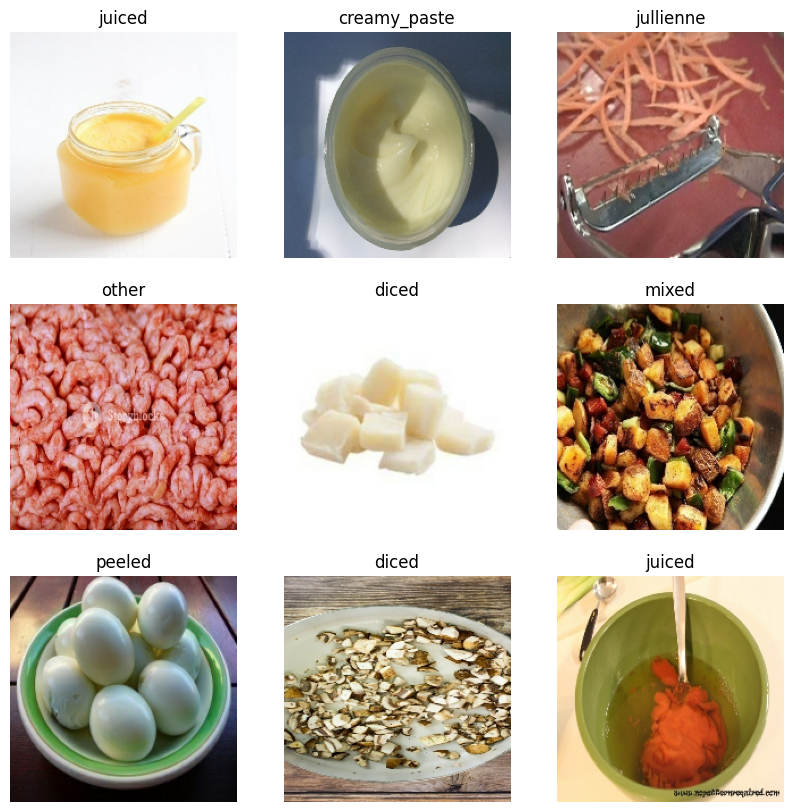

In [ ]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# for image_batch, labels_batch in train_ds:
#   print(image_batch.shape)
#   print(labels_batch.shape)
#   break

In [ ]:
#Configuring dataset for performance
# AUTOTUNE = tf.data.AUTOTUNE
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)


#save datasets as numpy array in memory for faster access

# Model Creating and Training

In [ ]:
num_classes = 11

#use rescaling layer to normalize inputs.
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        1

In [ ]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs
)

Epoch 1/10
226/226 [==============================] - 2334s 10s/step - loss: 2.2482 - accuracy: 0.1919 - val_loss: 2.1489 - val_accuracy: 0.2346
Epoch 2/10
226/226 [==============================] - 40s 174ms/step - loss: 1.9939 - accuracy: 0.3039 - val_loss: 1.9702 - val_accuracy: 0.3046
Epoch 3/10
226/226 [==============================] - 40s 173ms/step - loss: 1.7428 - accuracy: 0.3961 - val_loss: 2.0188 - val_accuracy: 0.3085
Epoch 4/10
226/226 [==============================] - 39s 170ms/step - loss: 1.2934 - accuracy: 0.5555 - val_loss: 2.3218 - val_accuracy: 0.3240
Epoch 5/10
226/226 [==============================] - 40s 173ms/step - loss: 0.8112 - accuracy: 0.7320 - val_loss: 2.8856 - val_accuracy: 0.3189
Epoch 6/10
226/226 [==============================] - 40s 174ms/step - loss: 0.4933 - accuracy: 0.8368 - val_loss: 3.5951 - val_accuracy: 0.3001
Epoch 7/10
226/226 [==============================] - 42s 181ms/step - loss: 0.3101 - accuracy: 0.9028 - val_loss: 4.1662 - val_ac

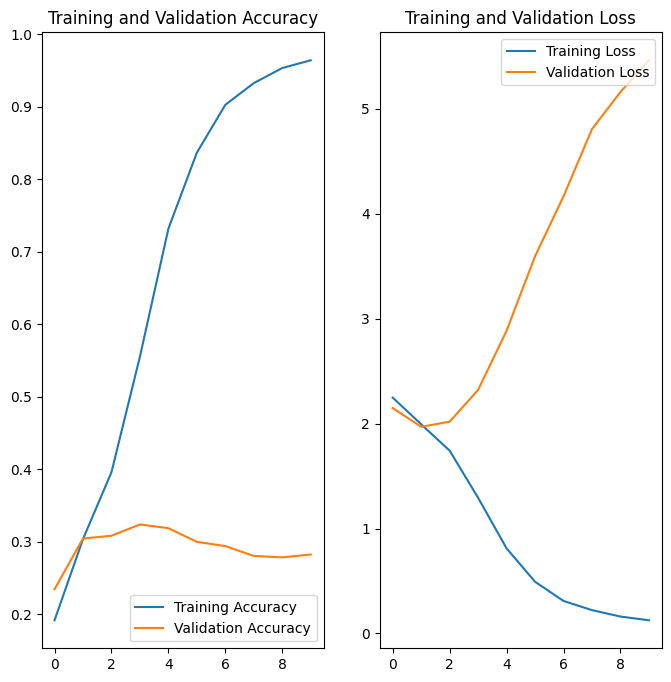

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Testing Script

In [ ]:
#load pretrained model and test it on a loaded test dataset to verify results

